# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/uk/middle_wallop/dat.txt'
# ipath= './data/NCDC/uk/southhamption/dat.txt'
# ipath= './data/NCDC/uk/bournemouth/dat.txt'
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/uk/holbeach/dat.txt"
# ipath= "./data/NCDC/uk/weybourne/dat.txt"
# ipath= "./data/NCDC/uk/cambridge/dat.txt"
# ipath= "./data/NCDC/uk/wattisham/dat.txt"
# ipath= "./data/NCDC/uk/lakenheath/dat.txt" # irregular sampling time
# ipath= "./data/NCDC/uk/mildenhall/dat.txt" # irregular sampling time

# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # recent 5 year maybe corrupted
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # high initial data
# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # corrupted
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt"  
# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt" # hard to fit
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt" # truncate
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # truancate dataset, try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # has 0 speed records
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem, weird direction distribution

# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; narror ellipse
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt"
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # 16 sectors

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # 
ipath= "./data/NCDC/cn/luogang/dat.txt"  # 
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # chi square 有问题
# ipath= "./data/NCDC/cn/wusu/dat.txt" # chi square 有问题, bandwidth 过小
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # 
# ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" # good
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real
# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # Wrong data

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,1.694210e+05,169421.000000,169421.000000,169421.000000,169421.000000
mean,2.003042e+07,1079.518242,161.005719,2.845010,148.911292
std,9.366379e+04,694.477088,117.853739,1.533157,101.474942
min,1.980010e+07,0.000000,0.000000,0.500000,0.000000
25%,1.998090e+07,500.000000,50.000000,2.000000,70.000000
50%,2.005081e+07,1000.000000,140.000000,3.000000,130.000000
75%,2.010092e+07,1700.000000,290.000000,4.000000,220.000000
max,2.015123e+07,2300.000000,350.000000,20.000000,350.000000


False


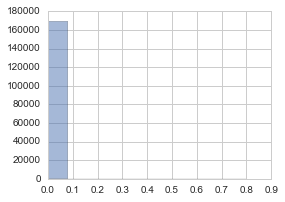

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

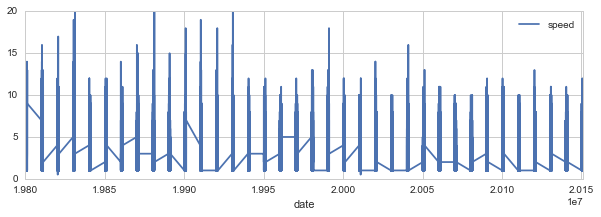

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

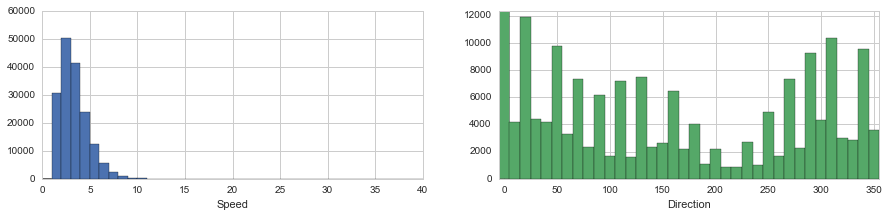

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19881227,19881227,1200,FM-12,250,20.0,200,0.0,17.0,19.0
19930602,19930602,1200,FM-12,240,20.0,210,0.0,15.0,17.0
19831230,19831230,900,FM-12,90,20.0,0,0.0,17.0,19.0
19910421,19910421,0,FM-12,350,19.0,100,0.0,18.0,17.0
19830428,19830428,900,FM-12,130,19.0,320,0.0,10.0,13.0
19920818,19920818,1800,FM-12,50,18.0,40,0.0,12.0,16.0
19991108,19991108,2100,FM-12,0,18.0,90,0.0,16.0,16.0
19900916,19900916,1800,FM-12,250,18.0,200,0.0,17.0,17.0
19820728,19820728,600,FM-12,270,17.0,180,0.0,11.0,10.0


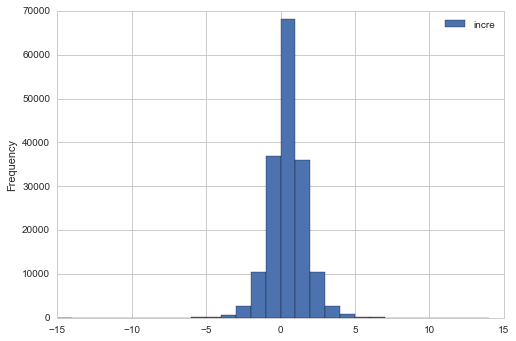

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 10


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19810502,19810502,0,FM-12,90,16.0,0,0.0,13.0,6.0
19820503,19820503,600,FM-12,160,15.0,290,0.0,2.0,8.0
19900908,19900908,0,FM-12,0,15.0,90,0.0,12.0,9.0
19910306,19910306,600,FM-12,0,14.0,90,0.0,11.0,8.0
19860107,19860107,600,FM-12,160,14.0,290,0.0,8.0,9.0
19801024,19801024,1800,FM-12,130,14.0,320,0.0,7.0,2.0
20020320,20020320,1000,FM-15,120,14.0,330,0.0,5.0,4.0
19810508,19810508,900,FM-12,350,14.0,100,0.0,4.0,8.0
19830316,19830316,300,FM-12,130,14.0,320,0.0,4.0,1.0


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0      12309
10      4214
20     11911
30      4420
40      4178
50      9799
60      3272
70      7331
80      2337
90      6148
100     1672
110     7185
120     1639
130     7466
140     2306
150     2643
160     6467
170     2216
180     4008
190     1065
200     2186
210      862
220      833
230     2739
240      993
250     4900
260     1644
270     7350
280     2258
290     9275
300     4314
310    10387
320     3008
330     2889
340     9570
350     3607
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

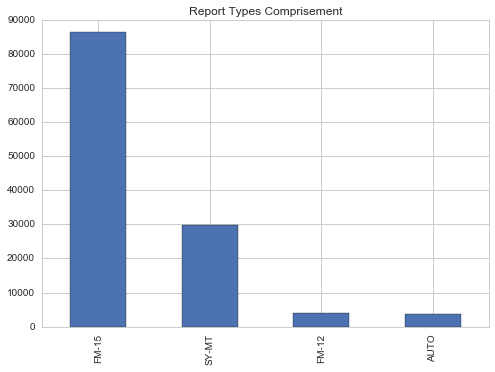

In [14]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

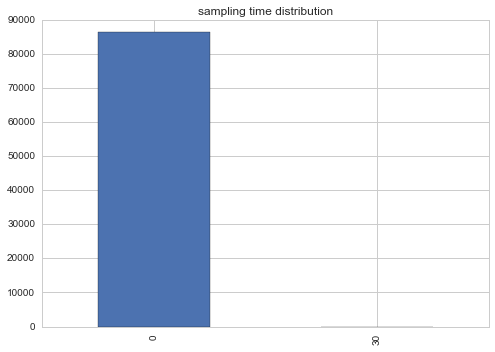

In [15]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = sample_time.value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0        731
100     5108
200     5191
300      751
400     5205
500     5193
600      707
700     5229
800     5284
900      814
1000    5218
1100    5129
1200     805
1300    5029
1400    4951
1500    4705
1600    4347
1700    3937
1800     753
1900    3500
2000    3541
2100     762
2200    4786
2300    4778
Name: HrMn, dtype: int64

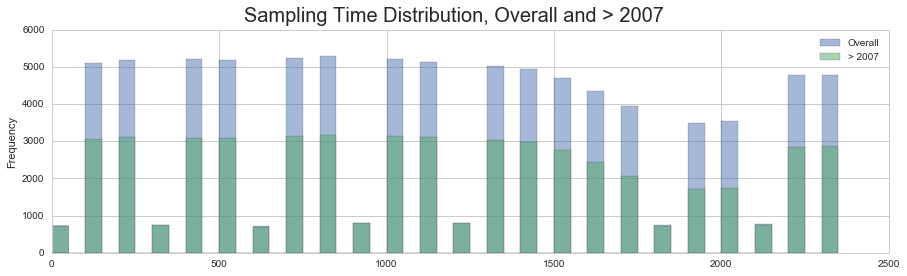

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

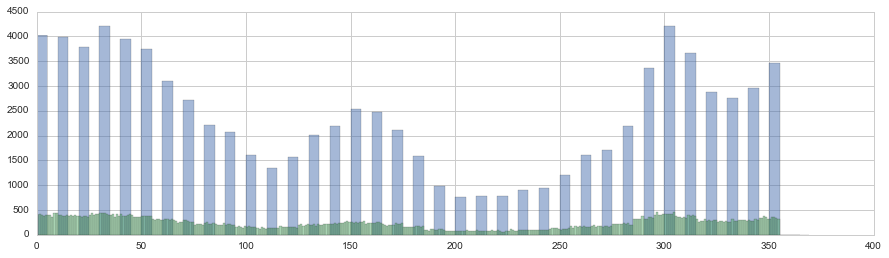

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

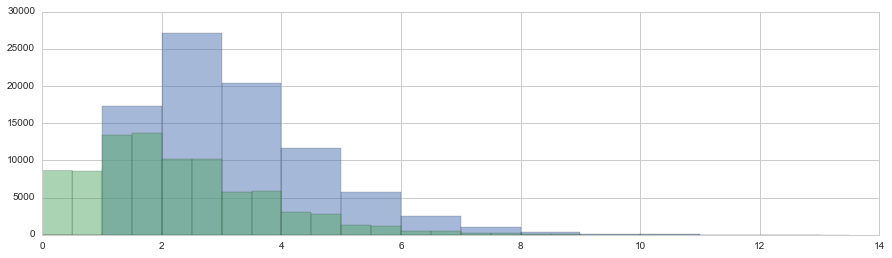

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

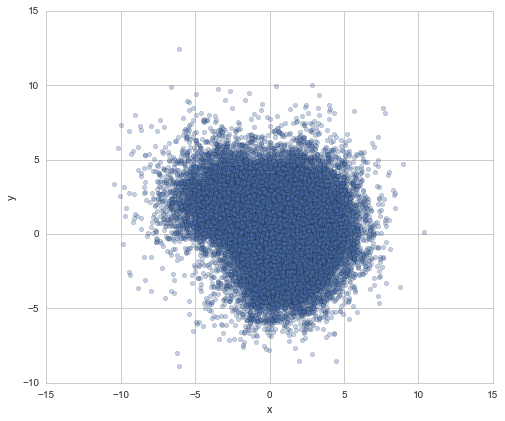

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

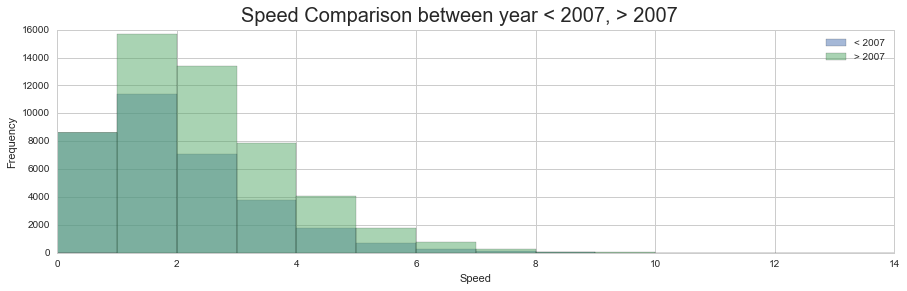

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

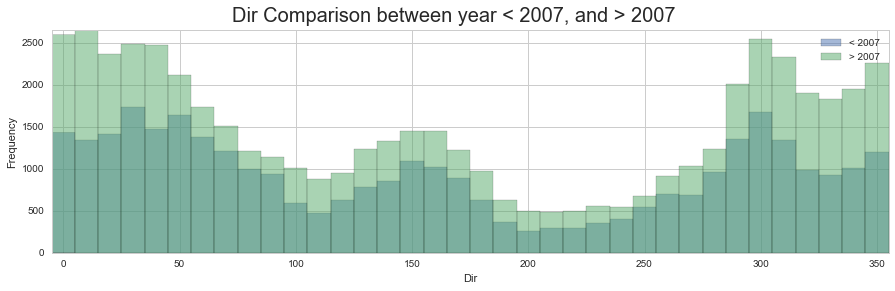

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

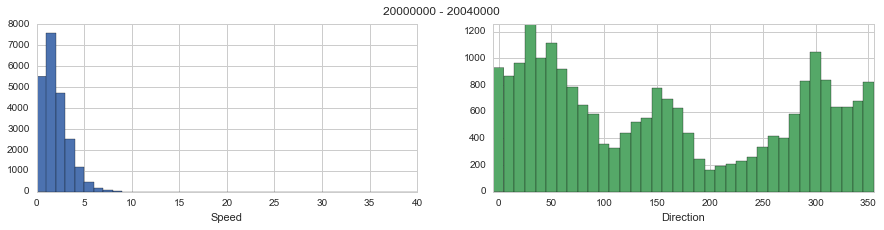

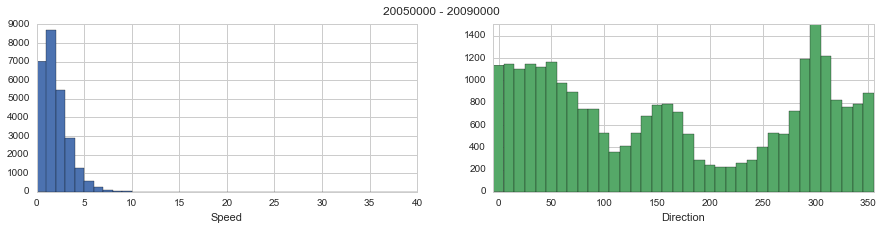

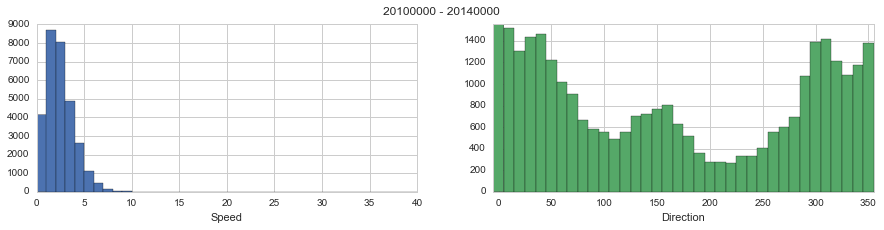

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 10
Report type used: FM-15
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,3.020700e+04,30207.000000,30207.000000,30207.000000,30207.000000,30207.0,30207.000000,30207.000000,30207.000000,30207.000000
mean,2.012292e+07,1139.808654,166.675287,2.488159,144.335088,0.0,0.154501,0.154037,0.688943,0.143111
std,1.428150e+04,674.515040,121.828227,1.502542,97.733404,0.0,1.010046,1.016911,2.003668,1.984678
min,2.010010e+07,0.000000,-4.992002,0.000919,0.000000,0.0,-6.000000,-10.000000,-10.475798,-8.869254
25%,2.011062e+07,500.000000,47.307677,1.398054,70.000000,0.0,0.000000,0.000000,-0.303262,-1.047309
50%,2.012112e+07,1100.000000,150.348696,2.271733,120.000000,0.0,0.000000,0.000000,0.891531,0.122739
75%,2.014010e+07,1600.000000,295.828775,3.363923,210.000000,0.0,1.000000,1.000000,1.916066,1.309452
max,2.014123e+07,2300.000000,354.996520,12.378644,350.000000,0.0,10.000000,7.000000,10.361821,9.884027


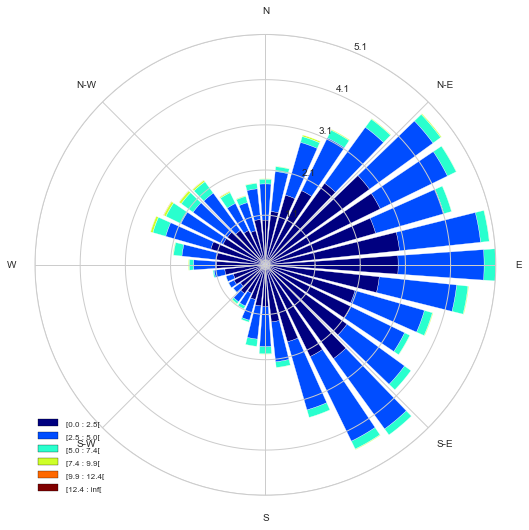

In [27]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

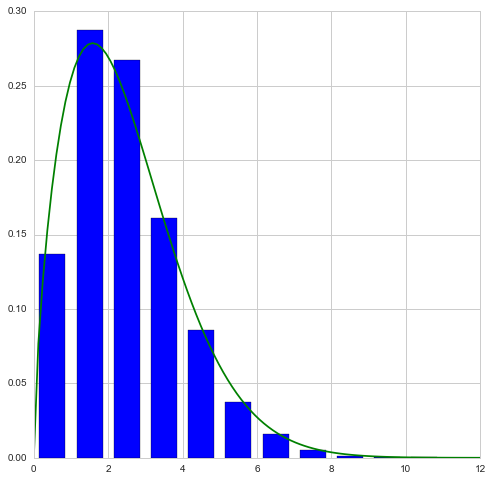

In [28]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

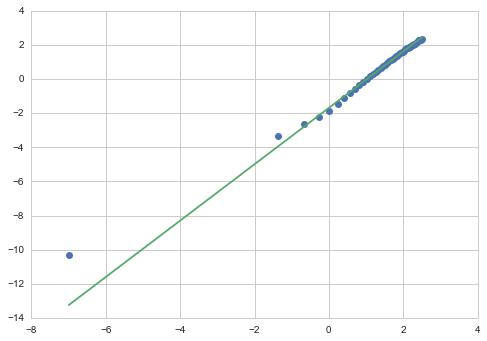

In [29]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [30]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7

In [31]:
FITTING_RANGE = []
fit_limit = ceil(df['speed'].quantile(.95))
plot_limit = ceil(df['speed'].quantile(.975))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])
        
print fitting_axis_range

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.]


# 3. Kernel Density Estimation

In [32]:
sample = SPEED_SET

In [33]:
# # The bandwidth value sometimes would be too radical
# from sklearn.grid_search import GridSearchCV

# if knot_unit:
#     bandwidth_range = arange(0.5,2,0.2)
# else:
#     bandwidth_range = arange(0.4,1,0.1)

# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': bandwidth_range},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# bandwidth = grid.best_params_['bandwidth']

In [34]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH 

kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 0.7 169
[  1.45088471e-05   8.08561176e-06   6.99450005e-06   1.82317713e-05
   6.48128112e-05]


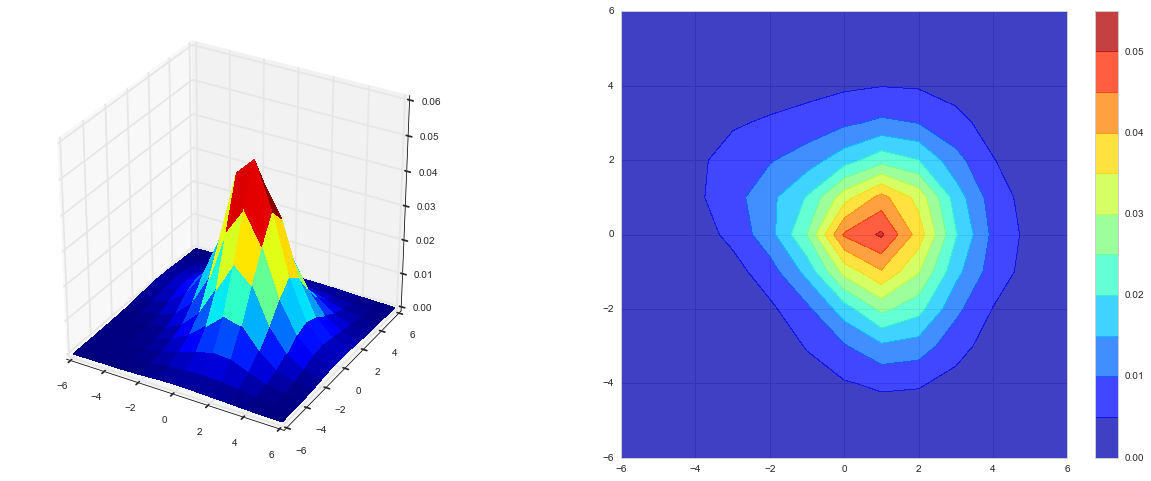

In [35]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [36]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [37]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [38]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.392786,0.907327,-0.903028,1.400372,1.800399,-0.024493
2,0.370729,1.562972,0.699233,1.597035,1.748799,0.026619
3,0.236485,-1.043962,1.008864,2.333427,1.851920,-0.407576


GMM Plot Result
0.392786042835 [[ 0.90732712 -0.90302767]] [ 1.3993108   1.80122396] -177.245140305
0.370728918462 [[ 1.56297152  0.69923306]] [ 1.5936933   1.75184473] 171.839450438
0.236485038703 [[-1.04396157  1.0088642 ]] [ 1.5518083   2.54290813] -120.112866663


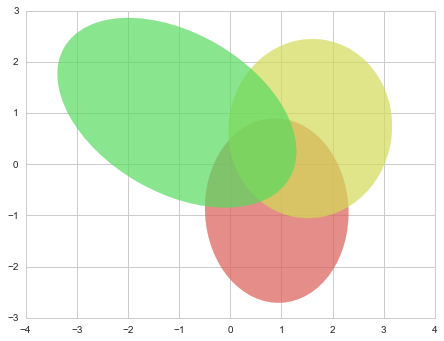

In [39]:
plot_gmm_ellipses(gmm_em_result)

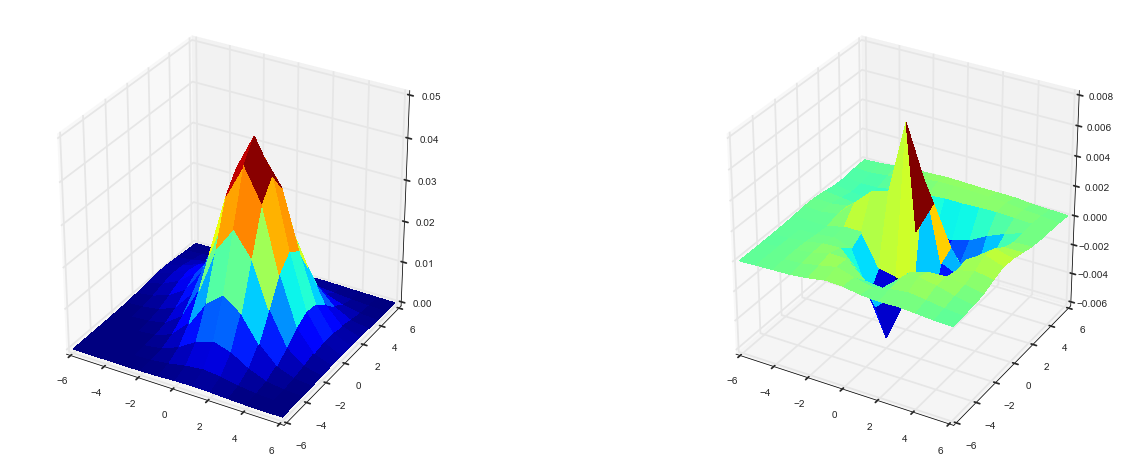

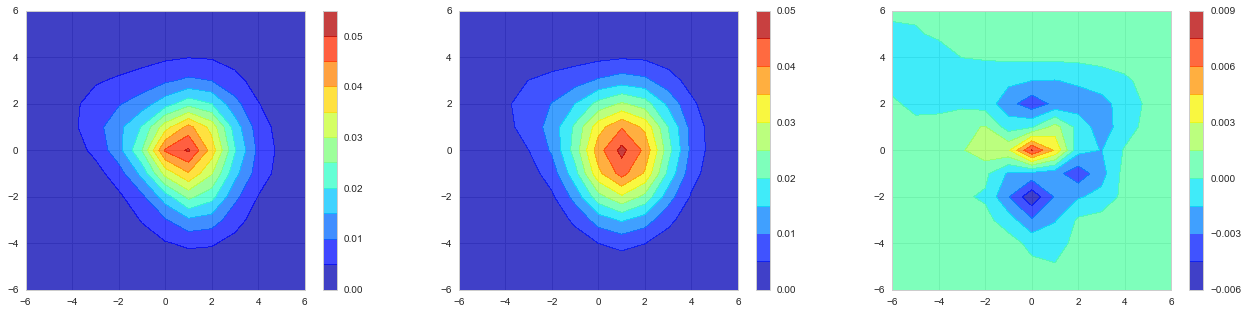

In [40]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [41]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.205875,0.025515,0.000002,0.024868,0.215829,0.982649


# 5. Least Square Prob Estimation

In [42]:
sample = SPEED_SET
points = FITTING_RANGE

In [43]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
        # {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        # {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points,FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -15.491583466930699
     jac: array([  4.13226509e+00,  -8.34465027e-07,   0.00000000e+00,
        -7.15255737e-07,  -4.76837158e-07,   5.60283661e-06,
         4.13226998e+00,  -1.19209290e-07,  -1.19209290e-07,
         7.15255737e-07,  -1.07288361e-06,   1.19209290e-07,
         4.13226914e+00,   5.96046448e-07,   1.78813934e-06,
        -2.98023224e-06,   1.43051147e-06,   8.34465027e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1083
     nit: 52
    njev: 52
  status: 0
 success: True
       x: array([ 0.49486715,  0.2278249 ,  0.55007369,  2.68576752,  2.0084581 ,
       -0.26857394,  0.10884599,  0.28922372,  0.13214119,  1.08128444,
        0.83278903,  0.15249769,  0.39628686,  1.38349592, -0.43703305,
        1.2612338 ,  2.12491819,  0.17700778])

## 5.1 GMM Result

In [44]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.494867,0.227825,0.550074,2.685768,2.008458,-0.268574
2,0.396287,1.383496,-0.437033,1.261234,2.124918,0.177008
3,0.108846,0.289224,0.132141,1.081284,0.832789,0.152498


GMM Plot Result
0.49486715094 [[ 0.2278249   0.55007369]] [ 1.86354149  2.78827263] -111.171870295
0.396286860161 [[ 1.38349592 -0.43703305]] [ 1.23113241  2.14249878] 171.013123968
0.1088459889 [[ 0.28922372  0.13214119]] [ 0.81039411  1.09816893] -74.9985178457


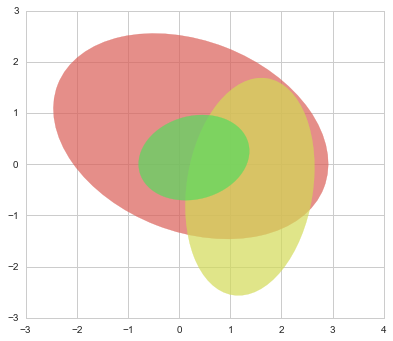

In [45]:
plot_gmm_ellipses(gmm)

## 5.2 Goodness-of-fit statistics

In [46]:
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.028866,0.006621,1.871073e-07,0.008507,0.073832,0.99797


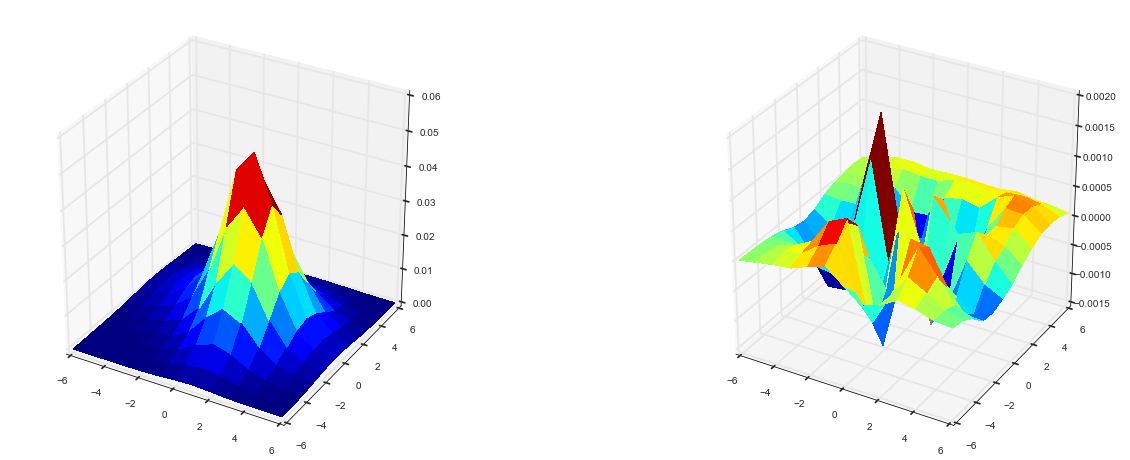

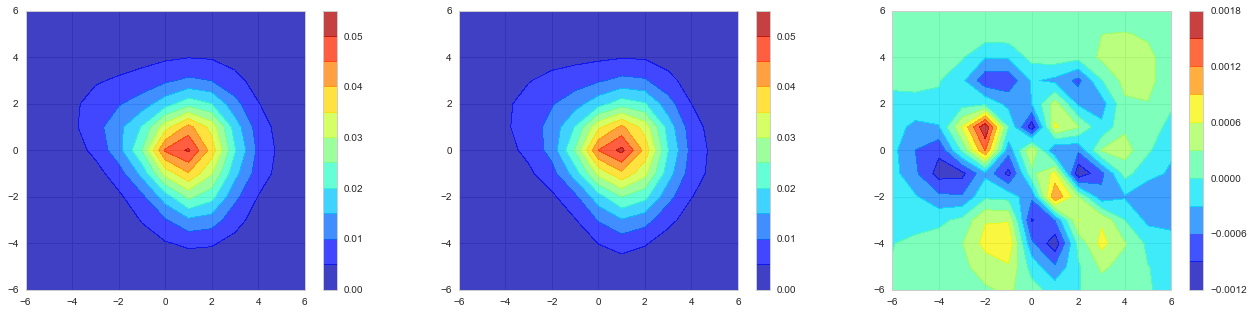

In [47]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [48]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

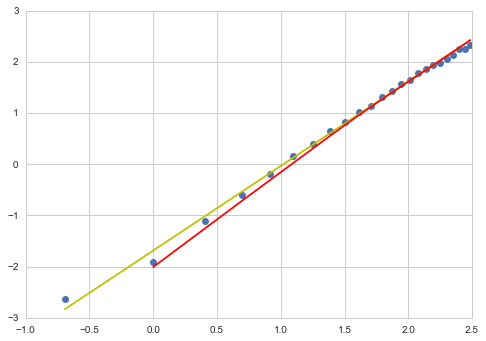

In [49]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

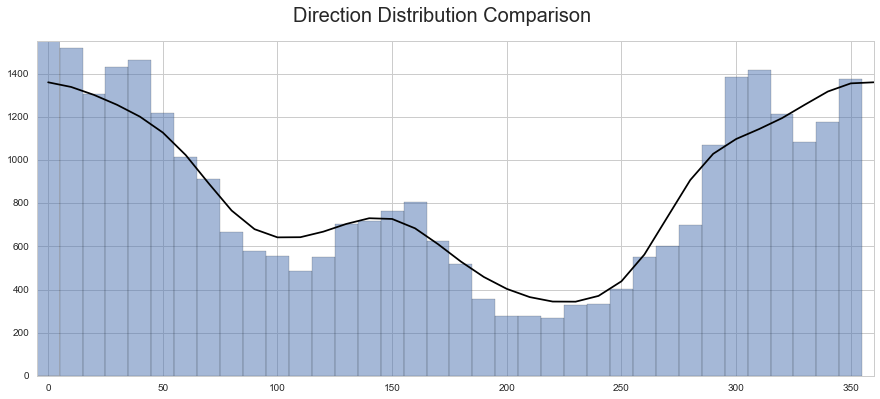

In [50]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

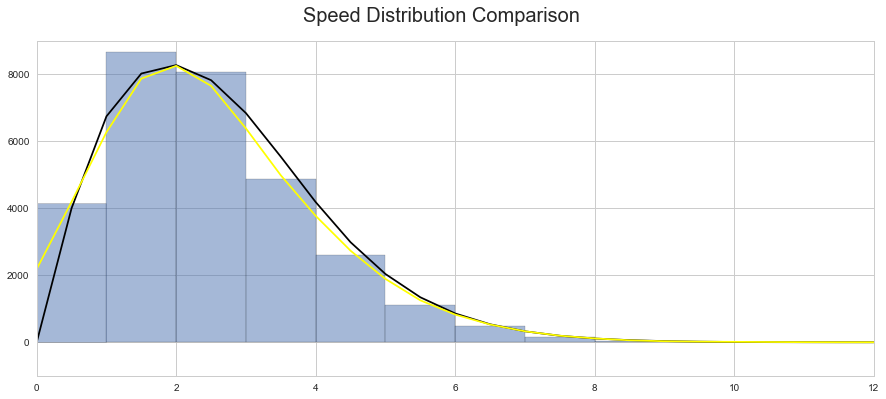

In [51]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

## 5.3 Sectoral Comaprison

In [52]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, 
                                         [[0, inf],
                                          [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = linspace(0, sub_max_speed, 20)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],
                   [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x = linspace(0, sub_max_speed, 20)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,3,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. Weibull plot
        ax4 = fig.add_subplot(1,3,3)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'data size:', len(sub_df)
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

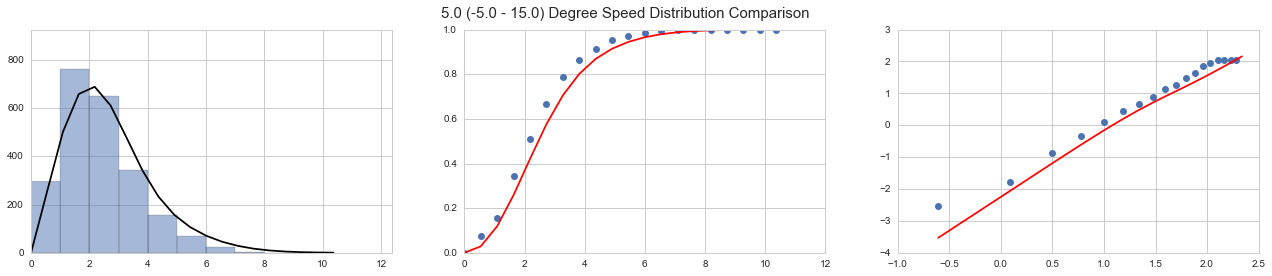

data size: 2306
max diff: 0.0898925903798 , speed value: 2.18169243235 y gmm 0.420515041884

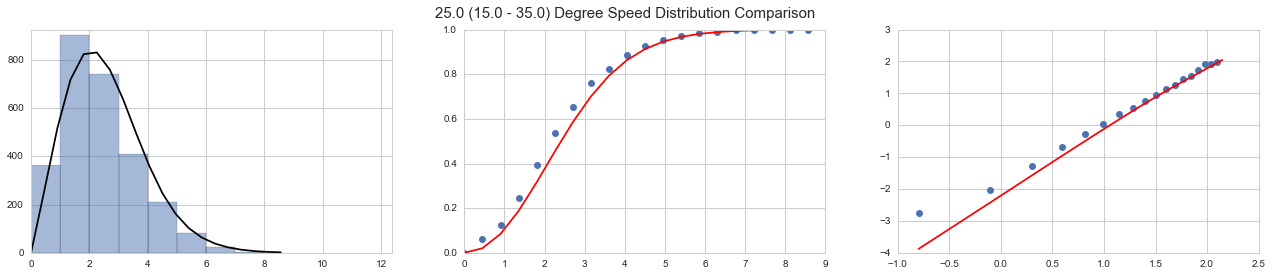

 data size: 2737
max diff: 0.0830619350849 , speed value: 2.25310158187 y gmm 0.453291736819

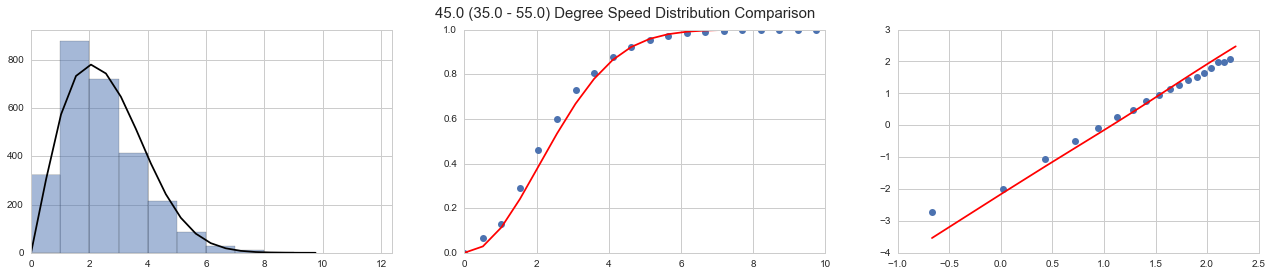

 data size: 2684
max diff: 0.0727811980883 , speed value: 2.05302429476 y gmm 0.387352930079

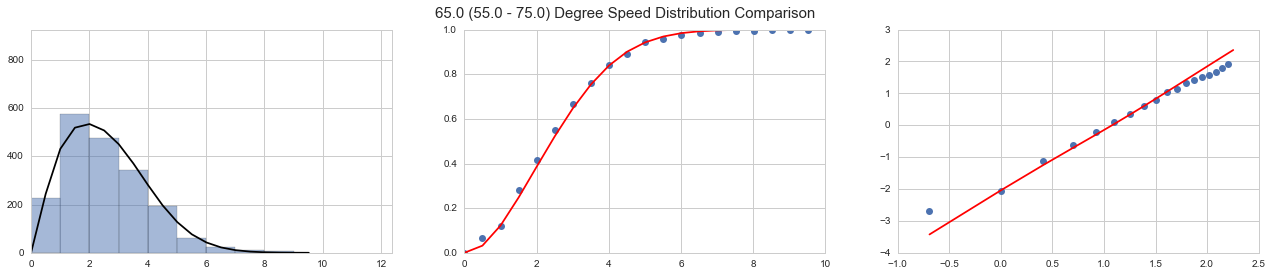

 data size: 1925
max diff: 0.0337087156629 , speed value: 1.50332024994 y gmm 0.247849725896

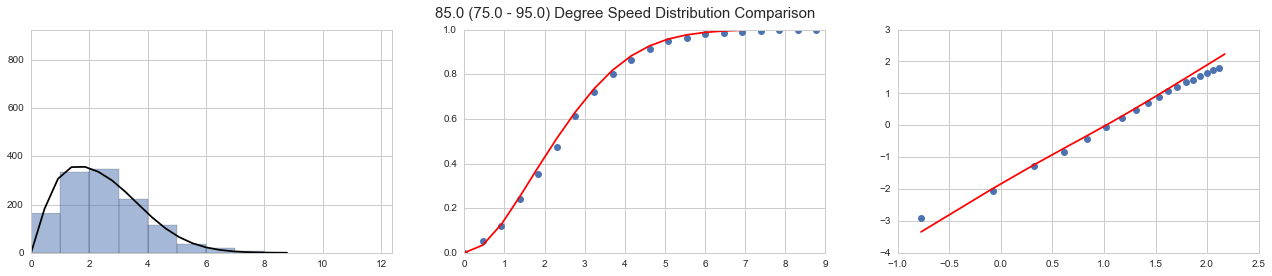

 data size: 1248
max diff: 0.0385488659856 , speed value: 2.30860209631 y gmm 0.513709122396

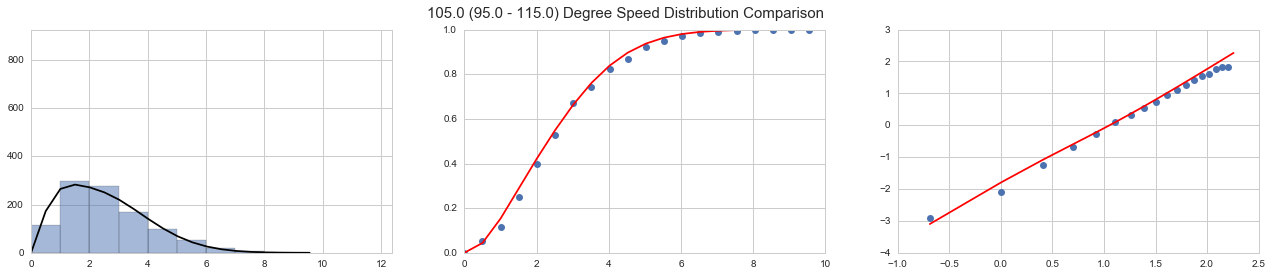

 data size: 1040
max diff: 0.0394908846029 , speed value: 1.00512933105 y gmm 0.153913961526

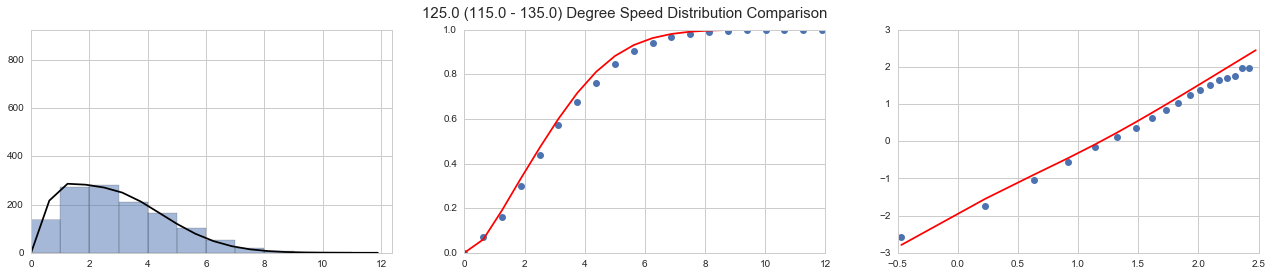

 data size: 1257
max diff: 0.0518167547122 , speed value: 4.37964845099 y gmm 0.81076663538

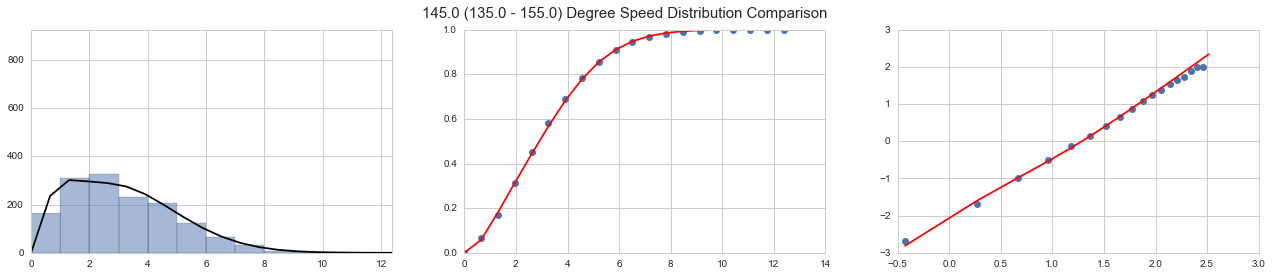

 data size: 1483
max diff: 0.0148443759782 , speed value: 3.25753784307 y gmm 0.566409838452

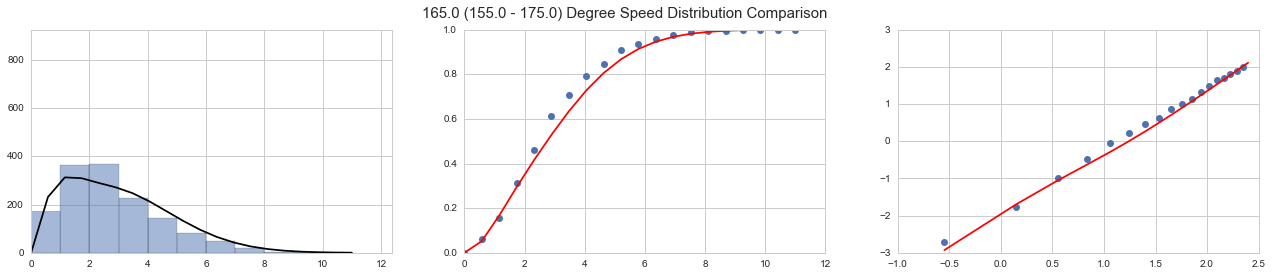

 data size: 1431
max diff: 0.0822438704546 , speed value: 2.89393794991 y gmm 0.528517834647

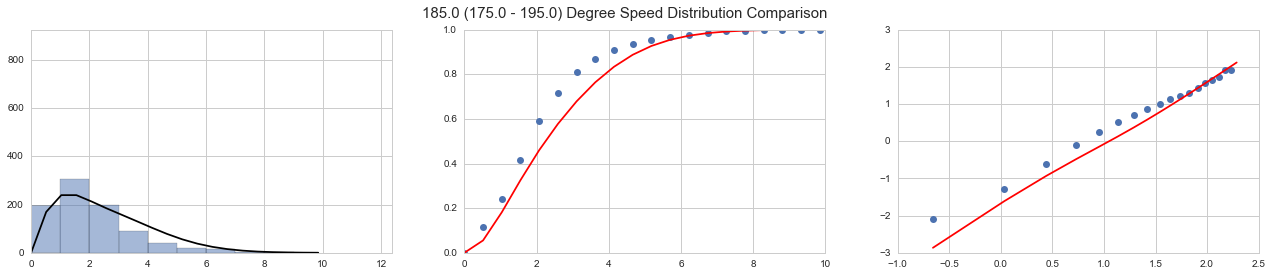

 data size: 874
max diff: 0.140088086028 , speed value: 2.59058457122 y gmm 0.57730321832

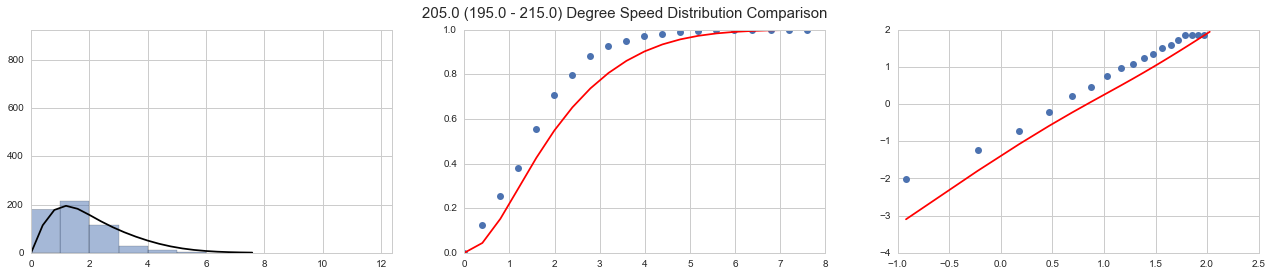

 data size: 555
max diff: 0.159858008961 , speed value: 1.99518375546 y gmm 0.548250099147

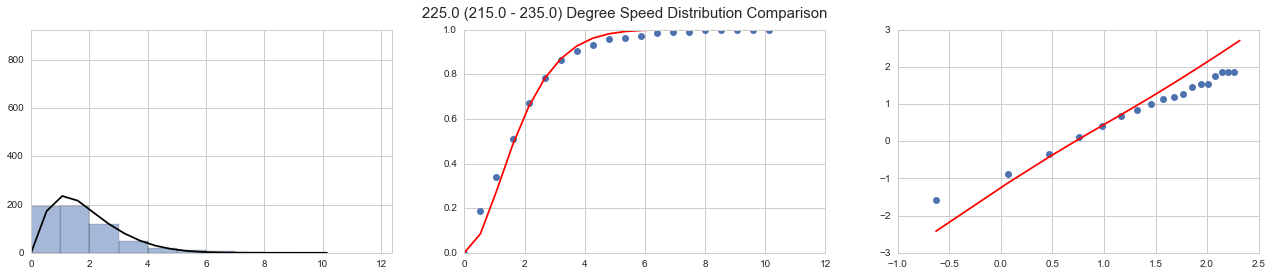

 data size: 598
max diff: 0.100376821622 , speed value: 0.533725285043 y gmm 0.0852419074755

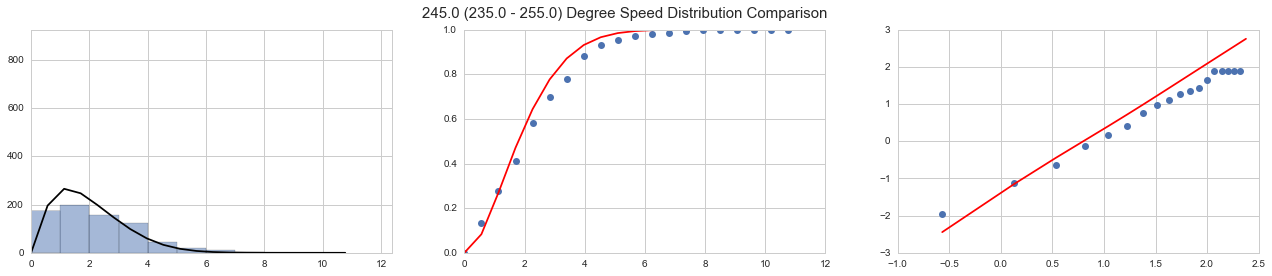

 data size: 734
max diff: 0.0941170614636 , speed value: 3.40114478921 y gmm 0.870683818957

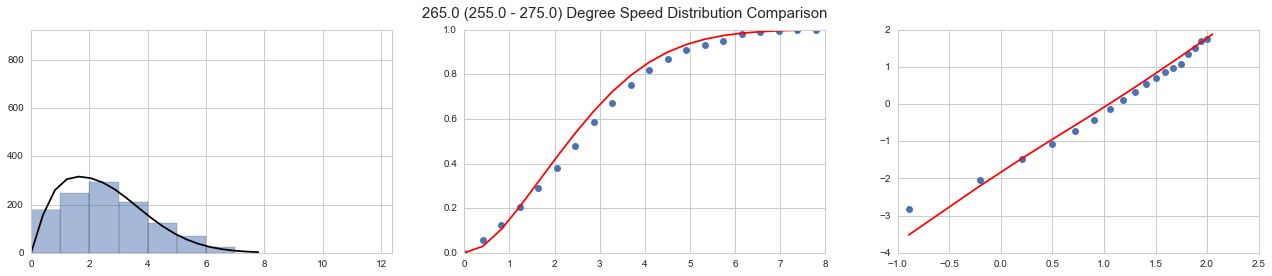

 data size: 1155
max diff: 0.0577317868529 , speed value: 2.45938954536 y gmm 0.536519665641

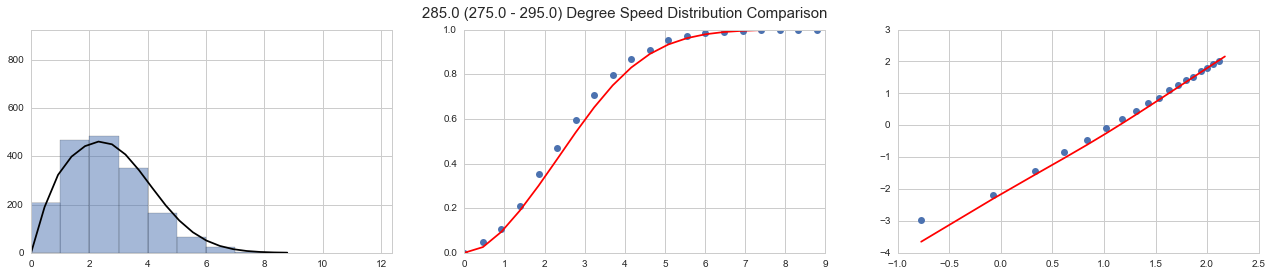

 data size: 1767
max diff: 0.0559225529548 , speed value: 2.77351477196 y gmm 0.538870882246

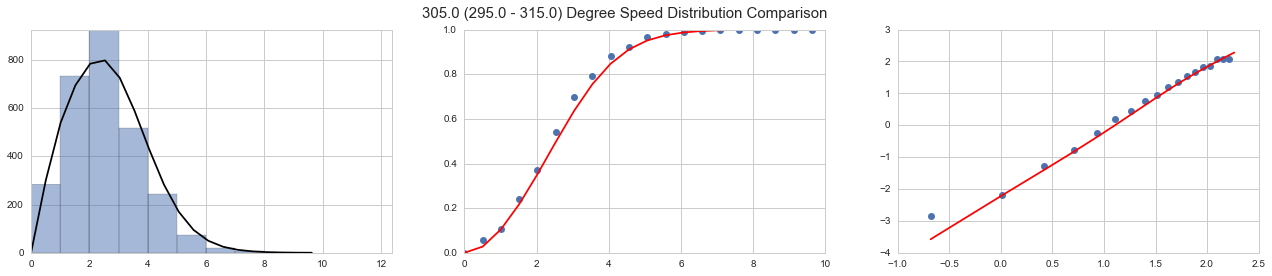

 data size: 2801
max diff: 0.0632679627709 , speed value: 3.03900631441 y gmm 0.63576809578

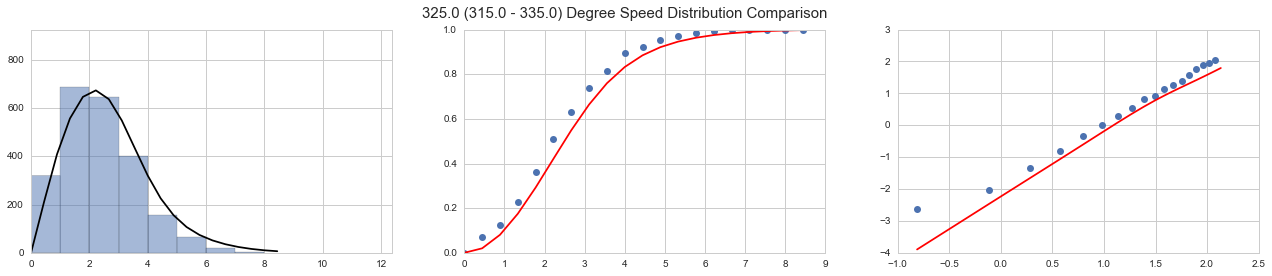

 data size: 2296
max diff: 0.0866299887645 , speed value: 2.22116800982 y gmm 0.42120973249

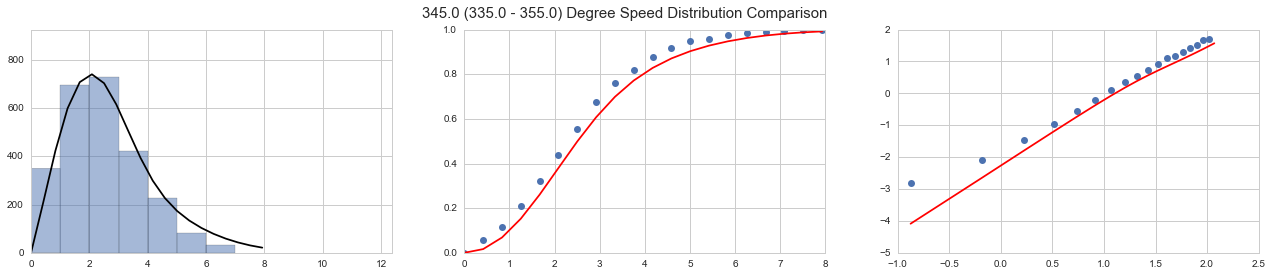

 data size: 2552
max diff: 0.0673940533436 , speed value: 2.92018237313 y gmm 0.607370836939


In [53]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

### 5.3.1 Variance over the years

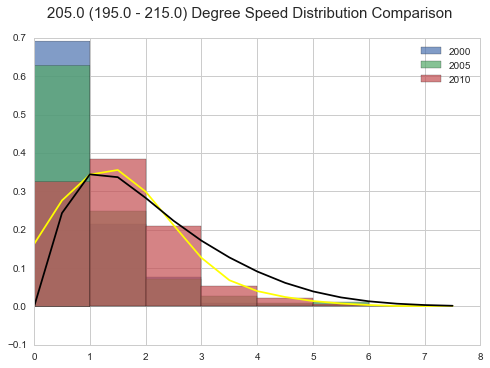

In [54]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), 
                                              normed=True,alpha=0.7,
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

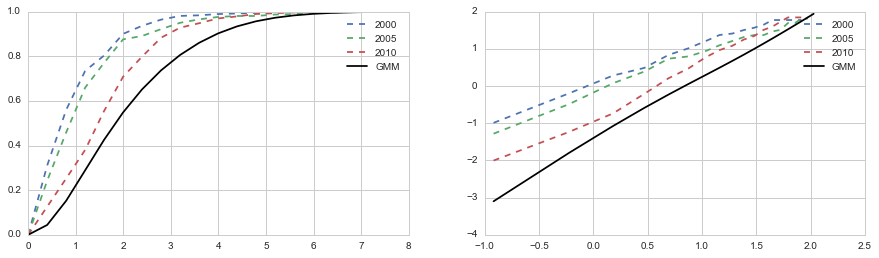

In [55]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,2,1) 
        plt.plot(x, y_cdf,'--', label = str(int(start_time/10000)))

        ax3 = fig.add_subplot(1,2,2) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--', label = str(int(start_time/10000)))
       
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black', label = 'GMM')
plt.legend()

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black',label = 'GMM')
plt.legend()

### 5.3.2 Bootstrap, to see the variance of each sector

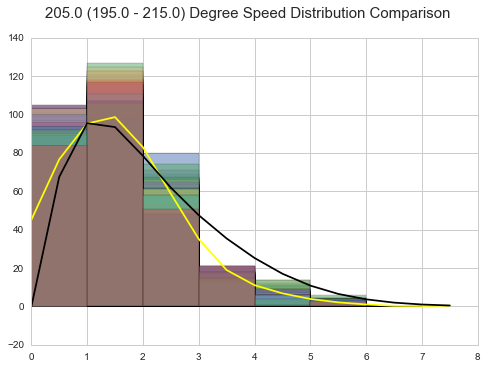

In [56]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))*len(sub_df.speed)*FRACTION
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

#2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0]/0.2 *len(sub_df.speed)*FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5)

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.131606015961 1.99518375546 0.548250099147


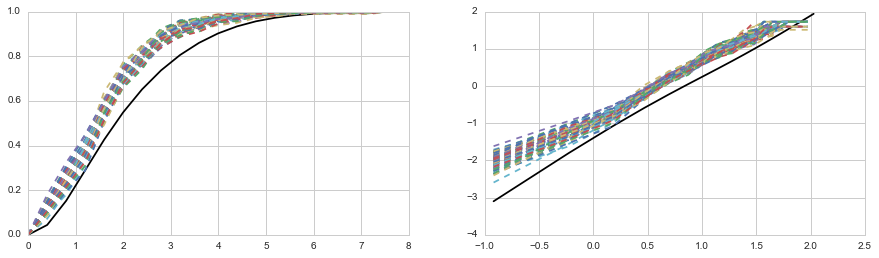

In [57]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,2,1) 
    plt.plot(x, y_cdf,'--')

    ax3 = fig.add_subplot(1,2,2) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# 6. Variance of results & Cross Validation

In [58]:
from sklearn.cross_validation import train_test_split, KFold

if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
    
points = FITTING_RANGE
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error'):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))
    
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-fit_limit, fit_limit),
             (-fit_limit, fit_limit),(0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
#             {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#             {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
           ]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, points, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)  
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_clf': kde,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit,
    }

## 6.1 Variance of the Result

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.496895,0.209763,0.601803,2.677583,1.988550,-0.254892
2,0.393092,1.362778,-0.504111,1.277985,2.127700,0.156039
3,0.110013,0.387182,0.174324,1.110737,0.825611,0.177511


GMM Plot Result
0.496894899395 [[ 0.20976319  0.60180332]] [ 1.85958162  2.76870693] -110.086271185
0.393092497703 [[ 1.36277816 -0.50411126]] [ 1.25392113  2.14197024] 171.828408088
0.110012602903 [[ 0.38718224  0.17432386]] [ 0.79825534  1.13055693] -74.7363723228


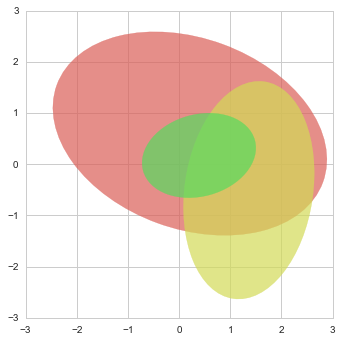

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.026336,0.007076,1.976239e-07,0.008723,0.075872,0.997847


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.483187,0.165335,0.529336,2.696351,2.002238,-0.269904
2,0.403251,1.394248,-0.398142,1.279005,2.145495,0.166044
3,0.113562,0.317124,0.140975,1.055930,0.844891,0.133034


GMM Plot Result
0.483187421752 [[ 0.16533516  0.52933578]] [ 1.85816393  2.79758713] -110.891691467
0.403250520643 [[ 1.3942476  -0.39814213]] [ 1.25198449  2.16137435] 171.463906297
0.113562057606 [[ 0.31712396  0.14097457]] [ 0.8254427   1.07120136] -74.6929731213


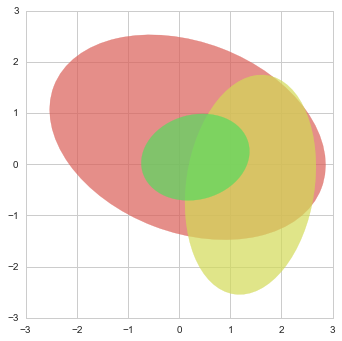

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.023685,0.006904,1.680488e-07,0.008,0.069956,0.998189


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.481654,0.216440,0.579020,2.713004,2.047005,-0.266331
2,0.400887,1.392213,-0.464090,1.274460,2.097954,0.166278
3,0.117458,0.292601,0.173795,1.137426,0.857754,0.182231


GMM Plot Result
0.481654428515 [[ 0.21643978  0.57901978]] [ 1.89929631  2.81838496] -111.509351275
0.40088711053 [[ 1.39221276 -0.46408983]] [ 1.24692074  2.11443744] 171.123149149
0.117458460955 [[ 0.29260055  0.17379501]] [ 0.82698773  1.15998785] -73.7464305086


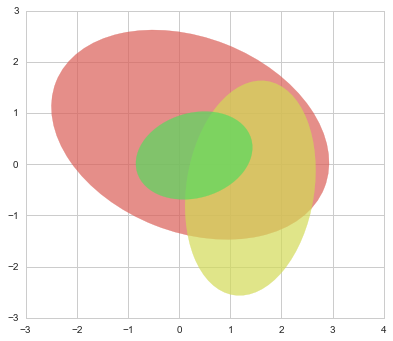

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.041787,0.006279,1.927390e-07,0.00872,0.074897,0.997897


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.493133,0.130471,0.449529,2.662114,2.027516,-0.309841
2,0.407735,1.384273,-0.323408,1.267725,2.172533,0.195151
3,0.099132,0.334519,0.159698,1.080494,0.820157,0.197512


GMM Plot Result
0.49313289787 [[ 0.13047139  0.44952875]] [ 1.83311602  2.79952824] -114.169125103
0.407734607639 [[ 1.38427326 -0.32340844]] [ 1.23163885  2.19319207] 170.474140444
0.0991324944918 [[ 0.33451909  0.15969804]] [ 0.78549551  1.10594843] -72.3610291189


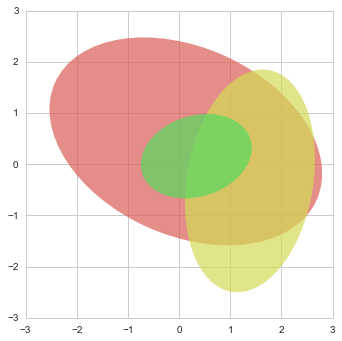

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.031945,0.00851,2.205510e-07,0.009307,0.080102,0.99758


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.485877,0.220999,0.534014,2.713826,2.027122,-0.270409
2,0.399570,1.371070,-0.431785,1.266880,2.120758,0.167566
3,0.114553,0.284142,0.111511,1.127124,0.853871,0.154815


GMM Plot Result
0.485876748905 [[ 0.22099946  0.53401358]] [ 1.87933115  2.81818943] -111.211420704
0.399570011786 [[ 1.37107049 -0.43178484]] [ 1.23957042  2.13683527] 171.354894143
0.114553239308 [[ 0.28414227  0.1115109 ]] [ 0.83114004  1.14398865] -75.5835779397


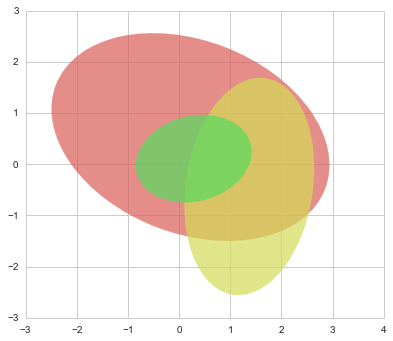

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.027985,0.005209,1.933404e-07,0.008683,0.075058,0.997901


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.483053,0.202790,0.595401,2.680475,2.028906,-0.260427
2,0.398124,1.422136,-0.440459,1.267550,2.080860,0.180772
3,0.118823,0.262412,0.105372,1.108123,0.851220,0.123575


GMM Plot Result
0.483053113634 [[ 0.20279026  0.59540125]] [ 1.88750598  2.78185696] -111.355569918
0.398123678621 [[ 1.42213648 -0.44045854]] [ 1.23515822  2.10024837] 170.350752077
0.118823207745 [[ 0.26241158  0.10537243]] [ 0.83599886  1.11965146] -77.574627666


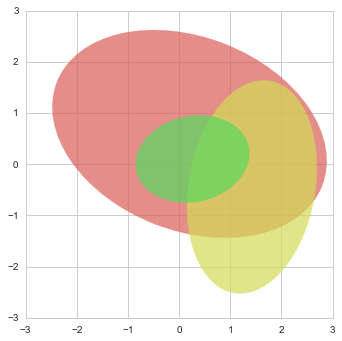

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.037681,0.006415,1.670647e-07,0.00798,0.06976,0.99821


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.494876,0.227516,0.543059,2.690451,2.049534,-0.275406
2,0.397258,1.381417,-0.387184,1.249390,2.106925,0.188152
3,0.107867,0.284214,0.135062,1.069274,0.839544,0.151038


GMM Plot Result
0.49487561667 [[ 0.2275162   0.54305917]] [ 1.88988081  2.80490031] -112.496870966
0.397257595275 [[ 1.38141719 -0.38718381]] [ 1.21578297  2.12649427] 170.504078478
0.107866788055 [[ 0.28421354  0.13506237]] [ 0.81627056  1.08714472] -74.1337026713


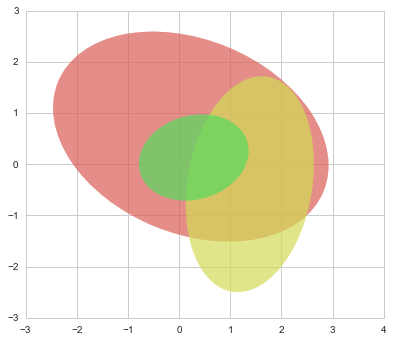

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.024346,0.007564,2.037112e-07,0.008863,0.077118,0.997794


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.489977,0.206927,0.578665,2.714087,2.001634,-0.264631
2,0.395391,1.339274,-0.467865,1.247287,2.087987,0.159571
3,0.114632,0.312931,0.172905,1.138922,0.850402,0.173440


GMM Plot Result
0.489976530019 [[ 0.20692744  0.57866512]] [ 1.8642291   2.81024136] -110.278540421
0.395391313984 [[ 1.33927432 -0.46786487]] [ 1.22287756  2.10237622] 171.744590731
0.114632155997 [[ 0.31293054  0.17290515]] [ 0.82318478  1.1587462 ] -74.8286824645


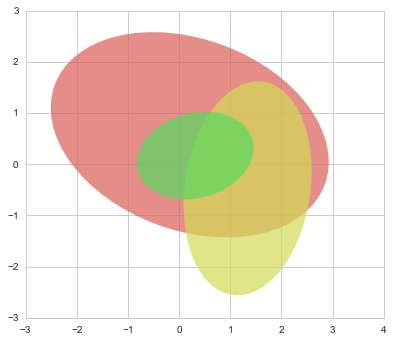

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029746,0.0084,2.366384e-07,0.009488,0.08306,0.997469


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.488555,0.241965,0.580372,2.670382,1.981780,-0.268902
2,0.396465,1.404963,-0.428886,1.269983,2.172735,0.190461
3,0.114980,0.234435,0.106293,1.077757,0.845698,0.144921


GMM Plot Result
0.488555373948 [[ 0.24196472  0.58037229]] [ 1.84027414  2.76979789] -110.809628913
0.396464573786 [[ 1.40496264 -0.42888647]] [ 1.23547291  2.19254176] 170.657278792
0.114980052266 [[ 0.23443509  0.10629292]] [ 0.82404198  1.09440391] -74.6902818293


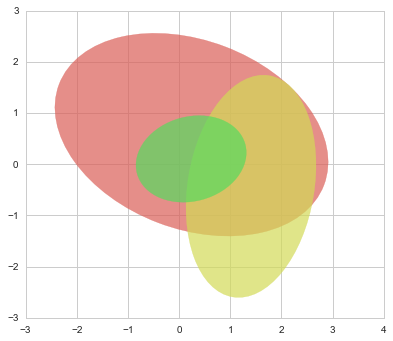

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.027735,0.006463,1.773358e-07,0.008363,0.071861,0.998076


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.538564,1.140945,-0.052302,1.378051,2.272235,0.112508
2,0.322328,-0.136957,0.268658,2.698138,2.063785,-0.671459
3,0.139108,0.851198,0.279490,2.279591,0.900380,0.366624


GMM Plot Result
0.538563689034 [[ 1.14094487 -0.05230172]] [ 1.36434381  2.28049138] 173.909422277
0.322328386782 [[-0.13695701  0.26865765]] [ 1.31799129  3.130823  ] -124.00170749
0.139107924184 [[ 0.85119805  0.27948997]] [ 0.82774917  2.30695675] -80.5302638197


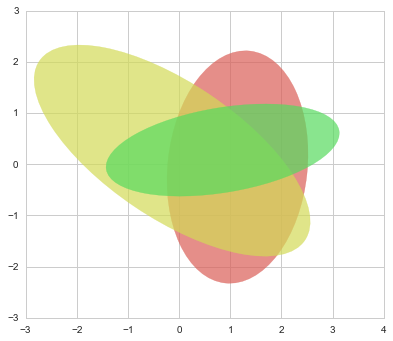

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.259035,0.01011,4.610112e-07,0.01357,0.115949,0.994955


In [59]:
for i in range(10):
    df_resampled = df.sample(frac=1, replace=True)
    result = fit_gmm(df_resampled, NUMBER_OF_GAUSSIAN, fit_method = FIT_METHOD)
    display(pretty_print_gmm(result['gmm']))
    plot_gmm_ellipses(result['gmm'])
    pretty_pd_display([goodness_of_fit_summary(result['gmm_pdf_result'], result['kde_result'])])

## 6.2 Cross validation, to select the number of Gaussian

In [60]:
## 5-fold cross validation
gaussian_number_range = arange(1,7)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        CV_result_train.append(gof_train)
        CV_result_test.append(gof_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print 'Train'
    pretty_pd_display(CV_result_train)
    print 'Test'
    pretty_pd_display(CV_result_test)

Number of train/test dataset 22655.25 7551.75
  
Number of gaussian 1
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.124863,0.046430,0.000004,0.041394,0.358599,0.951874
1,0.127959,0.047862,0.000005,0.042138,0.364314,0.950359
2,0.133977,0.046083,0.000005,0.041834,0.362664,0.950876
3,0.126678,0.046318,0.000005,0.041686,0.364230,0.951167


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.147229,0.047097,0.000005,0.042362,0.369666,0.949857
1,0.120660,0.046030,0.000005,0.042690,0.374739,0.948374
2,0.115779,0.042404,0.000005,0.042111,0.366708,0.950384
3,0.160586,0.051161,0.000004,0.041630,0.353978,0.951684


  
Number of gaussian 2
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.197636,0.025291,0.000001,0.020173,0.174109,0.988624
1,0.207891,0.028638,0.000001,0.021464,0.188365,0.986865
2,0.120876,0.024812,0.000001,0.020531,0.176737,0.988310
3,0.177682,0.026572,0.000001,0.021391,0.186109,0.987181


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.195006,0.031805,0.000002,0.024627,0.217278,0.982834
1,0.234430,0.026835,0.000001,0.020726,0.173859,0.988548
2,0.256455,0.025203,0.000001,0.022826,0.202942,0.984888
3,0.111641,0.025980,0.000001,0.020543,0.176958,0.988119


  
Number of gaussian 3
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.030941,0.006972,1.879524e-07,0.008578,0.074010,0.997953
1,0.027181,0.006585,1.874406e-07,0.008489,0.073867,0.997973
2,0.024963,0.005945,1.822851e-07,0.008392,0.072861,0.998024
3,0.034200,0.007197,1.995356e-07,0.008763,0.076276,0.997832


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029480,0.009630,2.915781e-07,0.010431,0.092122,0.996871
1,0.059056,0.008656,2.959615e-07,0.010797,0.092971,0.996755
2,0.038069,0.009060,3.243114e-07,0.011217,0.097254,0.996472
3,0.021074,0.009267,2.632404e-07,0.010167,0.087464,0.997155


  
Number of gaussian 4
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.019310,0.004785,9.810997e-08,0.006118,0.053457,0.998944
1,0.017630,0.004876,9.680732e-08,0.006169,0.053084,0.998943
2,0.011539,0.007153,1.192198e-07,0.006794,0.058946,0.998710
3,0.015126,0.004985,1.002034e-07,0.006216,0.054050,0.998909


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.025946,0.007637,3.081155e-07,0.011148,0.094777,0.996582
1,0.021007,0.010409,2.608613e-07,0.009809,0.087293,0.997226
2,0.016734,0.009979,2.440239e-07,0.009702,0.084269,0.997333
3,0.019429,0.011420,3.329889e-07,0.011401,0.098386,0.996432


  
Number of gaussian 5
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.008597,0.005264,6.549175e-08,0.004999,0.043689,0.999294
1,0.008583,0.004390,6.931896e-08,0.005198,0.044915,0.999244
2,0.006405,0.003607,6.206350e-08,0.004905,0.042526,0.999326
3,0.007659,0.005876,6.572183e-08,0.005050,0.043769,0.999286


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.010377,0.010272,1.765461e-07,0.008436,0.071679,0.998048
1,0.012067,0.004762,1.497812e-07,0.007523,0.066166,0.998402
2,0.011503,0.007664,1.464146e-07,0.007498,0.065292,0.998413
3,0.008762,0.011191,1.681845e-07,0.008025,0.069944,0.998180


  
Number of gaussian 6
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.003105,0.001658,1.060588e-08,0.002031,0.017580,0.999884
1,0.004772,0.001796,1.140083e-08,0.002088,0.018220,0.999877
2,0.004247,0.001382,1.340612e-08,0.002272,0.019764,0.999855
3,0.005746,0.001485,1.566535e-08,0.002475,0.021366,0.999830


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.008758,0.008034,1.221495e-07,0.006814,0.059635,0.998702
1,0.008690,0.012452,2.421646e-07,0.009851,0.084069,0.997354
2,0.007764,0.011932,1.552288e-07,0.007804,0.067240,0.998292
3,0.008808,0.008623,2.566861e-07,0.009808,0.086439,0.997225


In [61]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print 'Train gof mean, std'
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print 'Test gof mean, std'
display(test_scores_mean)

Train gof mean, std


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.128369,0.046673,4.509416e-06,0.041763,0.362452,0.951069
1,0.176021,0.026328,1.129828e-06,0.020890,0.181330,0.987745
2,0.029322,0.006675,1.893034e-07,0.008556,0.074254,0.997946
3,0.015901,0.005450,1.035851e-07,0.006324,0.054884,0.998876
4,0.007811,0.004784,6.564901e-08,0.005038,0.043725,0.999288
5,0.004467,0.001580,1.276954e-08,0.002216,0.019232,0.999861


Test gof mean, std


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.136064,0.046673,4.606930e-06,0.042199,0.366273,0.950075
1,0.199383,0.027456,1.286390e-06,0.022181,0.192760,0.986097
2,0.036920,0.009153,2.937729e-07,0.010653,0.092453,0.996814
3,0.020779,0.009861,2.864974e-07,0.010515,0.091181,0.996893
4,0.010677,0.008472,1.602316e-07,0.007870,0.068270,0.998261
5,0.008505,0.010260,1.940573e-07,0.008569,0.074346,0.997893


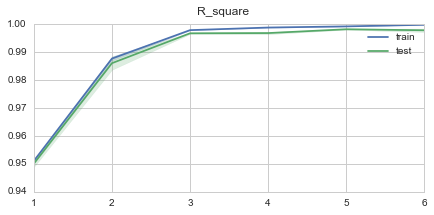

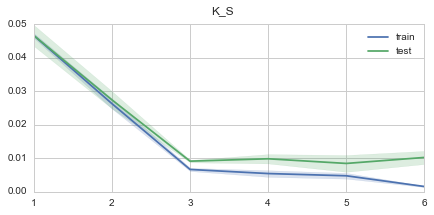

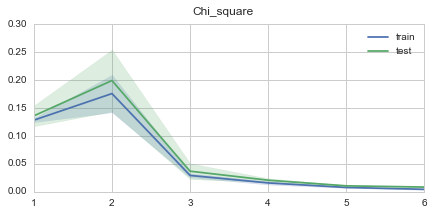

In [62]:
prop_cycle=sns.color_palette()
for column in ['R_square','K_S','Chi_square', ]:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, train_scores_mean[column],
             '-', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plt.plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.legend()
    plt.show()

In [63]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(ipath)
current_file = 'time_shift.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)

## 6.3 Variance of KDE

In [64]:
sss

NameError: name 'sss' is not defined

In [ ]:
%autosave??

In [ ]:
gmm1 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,
        0.055879,1.009152,-1.430799,2.10049,0.808011,0.08083,
        0.019425,-0.432981,2.574572,0.784784,0.796954,-0.020531]

gmm2 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,]

gmm3 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,]

gmms = [gmm1,gmm2,gmm3]
pdfs =[]

for gmm in gmms:
    plot_gmm_ellipses(gmm)
    gmm = group_gmm_param_from_gmm_param_array(gmm) 
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    X = Y = PLOT_AXIS_RANGE
    pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
    pdfs.append(pdf_Z)
    plot_2d_prob_density(X,Y,pdf_Z)

In [ ]:
plot_2d_prob_density(X,Y,pdfs[0]-pdfs[1])

In [ ]:
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    sub_df = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    sample = sub_speed_set = array(zip(sub_df.x, sub_df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    
    X = Y = PLOT_AXIS_RANGE
    kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    plot_2d_prob_density(X,Y,kde_Z,ax)
    plt.show()
#     plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir)

In [ ]:
# 5-fold cross validation
gaussian_number_range = arange(3,5)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_train = result['kde_clf']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        # Plot jPDF
        X = Y = PLOT_AXIS_RANGE
        kde_train_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_train.score_samples(coords)))
        fig = plt.figure(figsize=(22,6))
        ax1 = fig.add_subplot(1,3,1)
        plot_2d_prob_density(X,Y,kde_train_Z, ax1)
        
        ax2 = fig.add_subplot(1,3,2)
        kde_test_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_test.score_samples(coords)))
        plot_2d_prob_density(X,Y,kde_test_Z, ax2)
            
        ax3 = fig.add_subplot(1,3,3)
        plot_2d_prob_density(X,Y,kde_train_Z-kde_test_Z,ax3)
        
        pretty_pd_display([gof_train, gof_test], index=["gof_train", "gof_test"]))
        